# Impact Analytics assignment

In [1]:
import pandas as pd
import numpy as np
import json
import os
from multiprocessing import Pool
from tqdm.notebook import tqdm
import gc
import pickle
import joblib
import cv2
import bz2
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
REDUCE_MEM = True
MODEL_FILE_DIR = 'imaterialist2020-pretrain-models/'
attr_image_size = (160,160)

In [3]:
to_training = not os.path.isfile(MODEL_FILE_DIR+"maskmodel_%d.model"%attr_image_size[0])

In [4]:
train_df = pd.read_csv("imaterialist-fashion-2020-fgvc7/train.csv")

In [5]:
train_df.keys()

Index(['ImageId', 'EncodedPixels', 'Height', 'Width', 'ClassId',
       'AttributesIds'],
      dtype='object')

In [6]:
def rle_to_mask(rle_string,height,width):
    rows, cols = height, width
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rleNumbers = [int(numstring) for numstring in rle_string.split(' ')]
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        img = np.zeros(rows*cols,dtype=np.uint8)
        for index,length in rlePairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img

# Find the included attribute ID for each class ID

Getting the max class id

In [7]:
max_clz = train_df.ClassId.max()
print(max_clz)

45


In [9]:
"""
Creating step by step process, Remove comment from below code and run
"""
"""max_attr = 0
b = train_df.AttributesIds[1]
print(b)
for a in str(b).split(','):
    print(a)
    print(type(a))
    if a != 'nan':
        a = int(a)
        print(a)
        print(type(a))
        if a > max_attr:
            max_attr = a"""

115,136,142,146,225,295,316,317
115
<class 'str'>
115
<class 'int'>
136
<class 'str'>
136
<class 'int'>
142
<class 'str'>
142
<class 'int'>
146
<class 'str'>
146
<class 'int'>
225
<class 'str'>
225
<class 'int'>
295
<class 'str'>
295
<class 'int'>
316
<class 'str'>
316
<class 'int'>
317
<class 'str'>
317
<class 'int'>


Reading the Attributes id one by one, then in each attribute id, splitting all the value and converting them to integer to compare and get max attribute id

In [10]:
max_attr = 0
for i in train_df.AttributesIds:
    for a in str(i).split(','):
        if a!='nan':
            a = int(a)
            if a > max_attr:
                max_attr = a

In [11]:
print(max_attr)

340


# Flag of whether or not there is an attribute ID for each class ID is a two-dimensional array

Adding 1 in both max_clz and max_attr because both of them starts from 0 and goes till max value. So total size will be added by 1 in order to include 0

In [12]:
clz_attr = np.zeros((max_clz+1,max_attr+1))
clz_attrid2idx = [[] for _ in range(max_clz+1)]
clz_attr.shape

(46, 341)

In [13]:
for c,i in zip(train_df.ClassId,train_df.AttributesIds):
    for a in str(i).split(','):
        if a!='nan':
            a = int(a)
            clz_attr[c,a] = 1
            if not a in clz_attrid2idx[c]:
                clz_attrid2idx[c].append(a)

In [14]:
print(clz_attrid2idx)

[[115, 136, 142, 146, 225, 295, 316, 317, 135, 145, 147, 328, 304, 138, 298, 301, 320, 322, 137, 325, 148, 229, 318, 141, 302, 340, 114, 149, 327, 234, 305, 323, 140, 228, 338, 333, 296, 335, 227, 326, 313, 314, 319, 281, 336, 307, 134, 290, 331, 312, 321, 283, 116, 332, 306, 151, 128, 324, 297, 315, 339, 308, 162, 163, 150, 160, 204, 309, 153, 286, 330, 303, 310, 139, 337, 232, 143, 226, 231, 329, 300, 233, 126, 334], [0, 115, 145, 146, 295, 316, 317, 11, 135, 136, 314, 147, 301, 320, 141, 340, 149, 332, 114, 142, 319, 313, 14, 137, 318, 328, 9, 312, 325, 326, 281, 322, 2, 10, 308, 1, 13, 144, 12, 116, 8, 7, 305, 282, 285, 324, 4, 16, 148, 138, 140, 5, 304, 321, 331, 3, 283, 15, 327, 323, 6, 302, 307, 339, 139, 298, 310, 330, 160, 204, 296, 198, 299, 120, 315, 334, 333, 297, 306, 337, 290, 179, 338, 335, 182, 181, 293, 286, 309, 329, 311, 289, 150, 152, 183, 151, 134, 153, 155, 292, 154, 303, 159, 336, 133, 185, 300, 143, 197, 199], [136, 147, 295, 316, 317, 115, 142, 135, 145, 146, 3

# Indicates the number of attribute IDs for each class ID

In [15]:
clz_attr_num = clz_attr.sum(axis=1).astype(np.int64)
clz_attr_num

array([ 84, 110,  59,  67, 107,  69, 102,  89, 119, 105, 128,  86,  58,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   4,  21,   5,   0,  27,   8,  38,   0,   5,   1,   7,   0,
         1,   1,   0,   0,  13,   0,   0], dtype=int64)

You can see that some class IDs do not have attribute IDs associated with them

In [16]:
train_df

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219
...,...,...,...,...,...,...
333396,fffe20b555b98c3c1f26c8dfff275cbc,2712731 8 2715725 23 2718719 39 2721713 55 272...,3000,2001,28,163
333397,ffffbf7014a9e408bfbb81a75bc70638,71179 1 71678 3 72178 4 72678 4 73178 5 73679 ...,500,375,33,NaN
333398,ffffbf7014a9e408bfbb81a75bc70638,116648 5 117148 16 117648 22 118148 26 118647 ...,500,375,31,157
333399,ffffbf7014a9e408bfbb81a75bc70638,67711 1 68210 1 68709 2 69204 2 69208 3 69705 ...,500,375,31,157


4
['ffffbf7014a9e408bfbb81a75bc70638'
 '63365 36 63852 77 64343 85 64838 89 65332 94 65827 99 66321 106 66816 112 67300 129 67694 5 67711 1 67785 145 68185 15 68210 1 68281 149 68684 18 68709 2 68777 152 69183 22 69208 3 69273 156 69682 30 69769 160 70181 31 70230 12 70266 164 70680 32 70718 27 70762 169 71179 34 71215 33 71258 174 71678 73 71755 178 72178 255 72678 254 73178 254 73679 254 74179 256 74679 257 75179 257 75679 257 76179 256 76679 256 77179 256 77679 256 78179 256 78679 257 79179 258 79679 259 80178 260 80678 100 80781 157 81178 98 81281 157 81678 97 81781 157 82178 97 82281 157 82678 96 82785 153 83178 96 83286 152 83678 90 83770 3 83786 152 84178 89 84271 2 84285 154 84678 88 84771 2 84785 5 84792 148 85178 88 85271 1 85285 4 85292 149 85678 87 85771 1 85785 3 85792 149 86177 88 86284 4 86293 147 86677 87 86784 4 86793 146 87177 87 87284 3 87293 145 87676 87 87784 3 87793 145 88176 87 88284 3 88293 145 88676 87 88783 3 88793 145 89175 87 89283 3 89293 145 89675 87 89783

'res = []\nres.append((cid, mask, attr, X))\nAfter coming out of loop contains all classes, mask resized, attributes, roi x resized\n__getitem_ return res, resized image and image id'

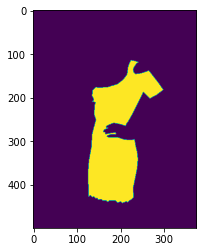

In [17]:
"""Creating step by step process. Remove multiline comment from below code and run to get the given output
"""

"""xe = train_df[train_df["ImageId"]=="ffffbf7014a9e408bfbb81a75bc70638"]
print(len(xe))
t=xe.values[3]
print(t)
class_id = t[4]
mask = rle_to_mask(t[1],t[2],t[3])    #rle_string,height,width
#xe=0
plt.imshow(mask)
attr = str(t[5]).split(",")
print(attr)
attr = map(int,str(t[5]).split(","))
print("Attribute")
print(attr)
where = np.where(mask != 0)
print("where")
print(where)
print(mask.shape)
xe = 0"""

#res = []
#res.append((cid, mask, attr, X))
#After coming out of loop contains all classes, mask resized, attributes, roi x resized
#__getitem_ return res, resized image and image id

In [18]:
def ptoz(obj):
    return bz2.compress(pickle.dumps(obj), 3) if REDUCE_MEM else obj
def ztop(b):
    return pickle.loads(bz2.decompress(b)) if REDUCE_MEM else b
def __getitem__(imgid):
    df = train_df[train_df.ImageId==imgid]
    res = []
    imag = cv2.imread("imaterialist-fashion-2020-fgvc7/train/"+str(imgid)+".jpg")
    for idx in range(len(df)):
        t = df.values[idx]
        cid = t[4]
        mask = rle_to_mask(t[1],t[2],t[3])
        attr = map(int,str(t[5]).split(",")) if str(t[5]) != 'nan' else []
        where = np.where(mask != 0)
        y1,y2,x1,x2 = 0,0,0,0
        if len(where[0]) > 0 and len(where[1]) > 0:
            y1,y2,x1,x2 = min(where[0]),max(where[0]),min(where[1]),max(where[1])
        if y2>y1+10 and x2>x1+10:
            X = cv2.resize(imag[y1:y2,x1:x2], attr_image_size)
            X = ptoz(X)
        else:
            X = None
        mask = cv2.resize(mask, attr_image_size)
        mask = ptoz(mask)
        res.append((cid, mask, attr, X))
    imag = cv2.resize(imag, attr_image_size)
    imag = ptoz(imag)
    return res, imag, imgid

In [19]:
if to_training:
    if os.path.isfile(MODEL_FILE_DIR+"data_cache_%d"%attr_image_size[0]):
        data_cache = joblib.load(MODEL_FILE_DIR+"data_cache_%d"%attr_image_size[0])
    elif REDUCE_MEM:
        data_cache = []
        for i in tqdm(list(set(train_df.ImageId))):
            res, imag, imgid = __getitem__(i)
            for cid, mask, attr, X in res:
                data_cache.append((cid, mask, attr, imag, X, imgid))
        joblib.dump(data_cache, MODEL_FILE_DIR+"data_cache_%d"%attr_image_size[0])
    else:
        with Pool(8) as p:
            tmp = p.map(__getitem__, list(set(train_df.ImageId)))
        data_cache = []
        for res, imag, imgid in tmp:
            for cid, mask, attr, X in res:
                data_cache.append((cid, mask, attr, imag, X, imgid))
        del tmp
        joblib.dump(data_cache, MODEL_FILE_DIR+"data_cache_%d"%attr_image_size[0])
else:
    data_cache = []

  0%|          | 0/45623 [00:00<?, ?it/s]

KeyboardInterrupt: 

Interrupted the kernel manually so that can show approach but real time training will take a lot of time

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return mish(input)

class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,activation=None):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        act = nn.ReLU() if activation is None else activation
        rep=[]

        rep.append(act)
        rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
        rep.append(nn.BatchNorm2d(out_filters))
        filters = out_filters

        for i in range(reps-1):
            rep.append(act)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x += skip
        return x

class AttrXception(nn.Module):
    def __init__(self, num_classes=1000):
        super(AttrXception, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 64, 3, 2, 1, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.mish = Mish()

        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(128)

        self.block1 = Block(128,256,2,2)
        self.block2 = Block(256,256,3,1)
        self.block3 = Block(256,256,3,1)
        self.block4 = Block(256,256,3,1)
        self.block5 = Block(256,256,3,1)
        self.block6 = Block(256,256,3,1)
        self.block7 = Block(256,384,2,2)

        self.conv3 = SeparableConv2d(384,512,3,stride=1,padding=0,bias=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.mish(x)

        x = self.conv2(x)
        x = self.bn2(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)

        x = self.mish(x)
        x = self.conv3(x)

        x = self.mish(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        result = self.fc(x)
        
        return torch.sigmoid(result)
    
class HourglassNet(nn.Module):
    def __init__(self, depth, channel):
        super(HourglassNet, self).__init__()
        self.depth = depth
        hg = []
        for _ in range(self.depth):
            hg.append([
                Block(channel,channel,3,1,activation=Mish()),
                Block(channel,channel,2,2,activation=Mish()),
                Block(channel,channel,3,1,activation=Mish())
            ])
        hg[0].append(Block(channel,channel,3,1,activation=Mish()))
        hg = [nn.ModuleList(h) for h in hg]
        self.hg = nn.ModuleList(hg)

    def _hour_glass_forward(self, n, x):
        up1 = self.hg[n-1][0](x)
        low1 = self.hg[n-1][1](up1)

        if n > 1:
            low2 = self._hour_glass_forward(n-1, low1)
        else:
            low2 = self.hg[n-1][3](low1)

        low3 = self.hg[n-1][2](low2)
        up2 = F.interpolate(low3, scale_factor=2)
        out = up1 + up2
        return out

    def forward(self, x):
        return self._hour_glass_forward(self.depth, x)

class XceptionHourglass(nn.Module):
    def __init__(self, num_classes):
        super(XceptionHourglass, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 128, 3, 2, 1, bias=True)
        self.bn1 = nn.BatchNorm2d(128)
        self.mish = Mish()

        self.conv2 = nn.Conv2d(128, 256, 3, 1, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(256)

        self.block1 = HourglassNet(4, 256)
        self.bn3 = nn.BatchNorm2d(256)
        self.block2 = HourglassNet(4, 256)

        self.sigmoid = nn.Sigmoid()

        self.conv3 = nn.Conv2d(256, num_classes, 1, bias=True)
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.mish(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.mish(x)

        out1 = self.block1(x)
        x = self.bn3(out1)
        x = self.mish(x)
        out2 = self.block2(x)

        r = self.sigmoid(out1 + out2)
        r = F.interpolate(r, scale_factor=2)
        
        return self.conv3(r)    


In [22]:
class AttrDataset(object):
    def __init__(self, chaches, clzid):
        self.clzid = clzid
        self.chaches = [cd for cd in chaches if cd[0]==clzid]

    def __getitem__(self, idx):
        cid, mask, attr, imag, X, imgid = self.chaches[idx]
        mask = ztop(mask)
        imag = ztop(imag)
        if X is None:
            X = imag
        else:
            X = ztop(X)
        y = np.zeros(clz_attr_num[self.clzid])
        for a in attr:
            y[clz_attrid2idx[self.clzid].index(a)] = 1
        return X.transpose((2,0,1)).astype(np.float32), y.astype(np.float32)
        
    def __len__(self):
        return len(self.chaches)

def train_attr_net(clzid, num_epochs=1):
    data = AttrDataset(data_cache, clzid)
    data_loader = torch.utils.data.DataLoader(
        data, batch_size=64, shuffle=True, num_workers=1)

    model = AttrXception(clz_attr_num[clzid])
    model.cuda()
    dp = torch.nn.DataParallel(model)
    loss = nn.BCELoss()

    params = [p for p in dp.parameters() if p.requires_grad]
    optimizer = torch.optim.RMSprop(params, lr=2.5e-4,  momentum=0.9)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=6,
                                                   gamma=0.9)
    
    prog = tqdm(list(range(num_epochs)))
    for epoch in prog:
        for i, (X, y) in enumerate(data_loader):
            X = X.cuda()
            y = y.cuda()
            xx = dp(X)

            losses = loss(xx, y)

            prog.set_description("loss:%05f"%losses)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        X, xx, y, losses = None, None, None, None
        torch.cuda.empty_cache()
        gc.collect()
    return model

# Training Attribute classification model

In [ ]:
for clzid in range(len(clz_attr_num)):
    if clz_attr_num[clzid] > 0:
        if not os.path.isfile(MODEL_FILE_DIR+"attrmodel_%d-%d.model"%(attr_image_size[0],clzid)):
            model = train_attr_net(clzid, 32)
            torch.save(model.state_dict(), MODEL_FILE_DIR+"attrmodel_%d-%d.model"%(attr_image_size[0],clzid))

In [ ]:
model = None
torch.cuda.empty_cache()
gc.collect()

Currently gpu not there so not trained

But if trained the trained model was saved to a file for later use after the above scripts

In [25]:
data_mask = dict()
while len(data_cache) > 0:
    cid, mask, _, imag, _, imgid = data_cache.pop()
    mask = ztop(mask)
    if imgid not in data_mask:
        imag = ztop(imag)
        data_mask[imgid] = [ptoz(imag.transpose((2,0,1)).astype(np.float32)), np.zeros(attr_image_size, dtype=np.int)]
    data_mask[imgid][1][mask!=0] = cid + 1

C:\Users\Lenovo\anaconda3\envs\nd\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [26]:
del data_cache
for k in data_mask.keys():
    data_mask[k][1] = ptoz(data_mask[k][1])
gc.collect()

72

# Next, train the mask image

In [28]:
class MaskDataset(object):
    def __init__(self, keys):
        self.keys = keys

    def __getitem__(self, idx):
        k = self.keys[idx]
        return ztop(data_mask[k][0]), ztop(data_mask[k][1])
        
    def __len__(self):
        return len(self.keys)

In [32]:
def train_mask_net(num_epochs=1):
    data = MaskDataset(list(data_mask.keys()))
    data_loader = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, num_workers=4)

    model = XceptionHourglass(max_clz+2)
    model.cuda()
    dp = torch.nn.DataParallel(model)
    loss = nn.CrossEntropyLoss()

    params = [p for p in dp.parameters() if p.requires_grad]
    optimizer = torch.optim.RMSprop(params, lr=2.5e-4,  momentum=0.9)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=6,
                                                   gamma=0.9)
    for epoch in range(num_epochs):
        total_loss = []
        prog = tqdm(data_loader, total=len(data_loader))
        for i, (imag, mask) in enumerate(prog):
            X = imag.cuda()
            y = mask.cuda()
            xx = dp(X)
            # to 1D-array
            y = y.reshape((y.size(0),-1))  # batch, flatten-img
            y = y.reshape((y.size(0) * y.size(1),))  # flatten-all
            xx = xx.reshape((xx.size(0), xx.size(1), -1))  # batch, channel, flatten-img
            xx = torch.transpose(xx, 2, 1)  # batch, flatten-img, channel
            xx = xx.reshape((xx.size(0) * xx.size(1),-1))  # flatten-all, channel

            losses = loss(xx, y)

            prog.set_description("loss:%05f"%losses)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss.append(losses.detach().cpu().numpy())
            break

        prog, X, xx, y, losses = None, None, None, None, None,
        torch.cuda.empty_cache()
        gc.collect()
    return model

In [ ]:
if to_training:
    model = train_mask_net(64)
    torch.save(model.state_dict(), MODEL_FILE_DIR+"maskmodel_%d.model"%attr_image_size[0])

In [34]:
del data_mask
gc.collect()

6569

# Predict Mask Image

In [36]:
class MaskDataset(object):
    def __init__(self, folder):
        self.imgids = [f.split(".")[0] for f in os.listdir(folder)]
        self.folder = folder

    def __getitem__(self, idx):
        imag = cv2.imread(self.folder+self.imgids[idx]+".jpg")
        imag = cv2.resize(imag, attr_image_size)
        return imag.transpose((2,0,1)).astype(np.float32)
        
    def __len__(self):
        return len(self.imgids)

In [ ]:
model = XceptionHourglass(max_clz+2)
model.cuda()
model.load_state_dict(torch.load(MODEL_FILE_DIR+"maskmodel_%d.model"%attr_image_size[0]))

dataset = MaskDataset("..imaterialist-fashion-2020-fgvc7/test/")

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=False, num_workers=4)

predict_imgeid = []
predict_mask = []
predict_rle = []
predict_classid = []
predict_attr = []

model.eval()
prog = tqdm(data_loader, total=len(data_loader))
num_pred = 0
for X in prog:
    X = X.cuda()
    pred = model(X).detach().cpu().numpy()
    for i, mask in enumerate(pred):
        imgid = dataset.imgids[num_pred]
        num_pred += 1
        pred_id = mask.argmax(axis=0) - 1  # -1 is background.
        for clz in set(pred_id.reshape((-1,)).tolist()):
            if clz >= 0:
                maskdata = (pred_id == clz).astype(np.uint8) * 255
                predict_imgeid.append(imgid)
                predict_mask.append(maskdata)
                predict_rle.append("")
                predict_classid.append(clz)
                predict_attr.append([])
prog, X, pred, dataset, data_loader = None, None, None, None, None
torch.cuda.empty_cache()
gc.collect()                

# After generating all mask images, cut out only the mask image part and put it in the saved model

In [37]:
import math
def _scale_image(img, long_size):
    if img.shape[0] < img.shape[1]:
        scale = img.shape[1] / long_size
        size = (long_size, math.floor(img.shape[0] / scale))
    else:
        scale = img.shape[0] / long_size
        size = (math.floor(img.shape[1] / scale), long_size)
    return cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)

In [38]:
for clzid in range(len(clz_attr_num)):
    if clz_attr_num[clzid] > 0 and os.path.isfile(MODEL_FILE_DIR+"attrmodel_%d-%d.model"%(attr_image_size[0],clzid)):
        model = AttrXception(clz_attr_num[clzid])
        model.cuda()
        model.eval()
        model.load_state_dict(torch.load(MODEL_FILE_DIR+"attrmodel_%d-%d.model"%(attr_image_size[0],clzid)))
        for i in range(len(predict_classid)):
            if predict_classid[i] == clzid:
                imag = cv2.imread("imaterialist-fashion-2020-fgvc7/test/"+predict_imgeid[i]+".jpg")
                imag = _scale_image(imag, 1024)
                mask = cv2.resize(predict_mask[i], (imag.shape[1],imag.shape[0]), interpolation=cv2.INTER_NEAREST)
                where = np.where(mask!=0)
                y1,y2,x1,x2 = 0,0,0,0
                if len(where[0]) > 0 and len(where[1]) > 0:
                    y1,y2,x1,x2 = min(where[0]),max(where[0]),min(where[1]),max(where[1])
                    if y2>y1+80 and x2>x1+80 and np.sum(mask)/255 > 1000:
                        print("class id=",clzid)
                        plt.subplot(1,2,1)
                        plt.imshow(imag)
                        plt.subplot(1,2,2)
                        plt.imshow(mask)
                        plt.show()
                        break

In [ ]:
uses_index = []
for clzid in tqdm(range(len(clz_attr_num))):
    if clz_attr_num[clzid] > 0 and os.path.isfile(MODEL_FILE_DIR+"attrmodel_%d-%d.model"%(attr_image_size[0],clzid)):
        model = AttrXception(clz_attr_num[clzid])
        model.cuda()
        model.eval()
        model.load_state_dict(torch.load(MODEL_FILE_DIR+"attrmodel_%d-%d.model"%(attr_image_size[0],clzid)))
        for i in range(len(predict_classid)):
            if predict_classid[i] == clzid:
                imag = cv2.imread("imaterialist-fashion-2020-fgvc7/test/"+predict_imgeid[i]+".jpg")
                imag = _scale_image(imag, 1024)
                mask = cv2.resize(predict_mask[i], (imag.shape[1],imag.shape[0]), interpolation=cv2.INTER_NEAREST)
                #imag[mask==0] = 255
                where = np.where(mask!=0)
                y1,y2,x1,x2 = 0,0,0,0
                if len(where[0]) > 0 and len(where[1]) > 0:
                    y1,y2,x1,x2 = min(where[0]),max(where[0]),min(where[1]),max(where[1])
                    if y2>y1+80 and x2>x1+80 and np.sum(mask)/255 > 1000:
                        predict_rle[i] = mask_to_rle(mask)
                        X = cv2.resize(imag[y1:y2,x1:x2], attr_image_size).transpose((2,0,1))
                        attr_preds = model(torch.tensor([X], dtype=torch.float32).cuda())
                        attr_preds = attr_preds.detach().cpu().numpy()[0]
                        for ci in range(len(attr_preds)):
                            if attr_preds[ci] > 0.5:
                                uses_index.append(i)
                                predict_attr[i].append(clz_attrid2idx[predict_classid[i]][ci])

# If the threshold (0.5) is exceeded, it is assumed that the attribute ID is included

In [ ]:
predict_attri_str = [",".join(list(map(str,predict_attr[i]))) for i in range(len(predict_classid))]